<a href="https://colab.research.google.com/github/ShegerKing/PriceForecasting/blob/master/Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.contrib import rnn
import matplotlib.pyplot as plt
import math
import time
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import TimeDistributed
from keras.layers import RepeatVector
from keras.layers import Dropout
from keras import optimizers

%matplotlib inline

   Our goal hear is to use an LSTM network to do time series forcasting with multiple features. LSTM's have been very sucessfull in the field of language processing and translation. The aim is get a feel for how good an RNN network is in making price forecasting. We will start of with a data that only includes market prices as well as add other technical instruments to predcit future values. Later one, we will be scarping data from news articles and do sentiment analysis along with the market data.


For the market data we are using the price of apple stock from 1984 to 2014. 

In [0]:

df = pd.read_csv('/content/drive/My Drive/appl.csv')
df = df.drop(['OpenInt', 'High', 'Low', 'Close'],1)
df.set_index('Date', inplace = True)
#A bit of feature enginerring to help the model learn better
df['ema_diff'] = df[['Open']].ewm(span = 20, adjust = False).mean()  - df[['Open']].ewm(span = 50, adjust = False).mean()

df.head(5)

,Open,Volume,ema_diff
Date,,,
1984-09-07,0.42388,23220030,0.000000
1984-09-10,0.42388,18022532,0.000000
1984-09-11,0.42516,42498199,0.000072
1984-09-12,0.42902,37125801,0.000350
1984-09-13,0.43927,57822062,0.001165


In [0]:
#scale the data
data = df.values
scaler = MinMaxScaler()
transform= scaler.fit_transform(data[:, 1].reshape(-1, 1))

data[:, 1] = transform.reshape(-1)


In [0]:
#split data into train and test
train = data[: int(0.85 * len(data))]
test = data[int(0.85*len(data)) :]
print(train.shape, test.shape)


(7109, 3) (1255, 3)


In [0]:
#define the number of days to forecast
n_out = 7 #week forecast

Our goal is to use (n_step) number of prior steps to predict the value of a stock for the coming weeks. To do so we split the training data into (n_step) individual data. But, for the current amount of  data we have that is about:

$$7109/7  \approx 1015$$

training data. We can increase the number of training data by sliding the  $7$ day steps by one over the entire training data. This will give us enough training data.

In [0]:
def batch_data(data, n_step):
    length = len(data)
    start = 0
    x_value, y_value = [], []
    for i in range(length):
        x_end = start + n_step
        y_end = x_end + n_out
        if y_end < length:
          x_value.append(data[start : x_end, :])
          y_value.append(data[x_end:y_end, 0 ])
          start += 1
    return np.array(x_value), np.array(y_value)

   We are going to build an LSTM layer to take advantage of the sequential nature of the problem. To make the forcasting we use encoder and decoder model. The first layer will be a encoder LSTM with 200 neurons that accepts multi-feature attributes. The output will be a 200 by num_steps vector. We use a RepeatVector to feed to the decoder. The decoder will be feed to a fully connected Dense layer. The time distributed layer allows us to do weight training over the individual timesteps. Finally we feed into a single Dense layer that outputs the values for the **n** days of forecasting

In [0]:
def build_graph(train, n_input, num_epochs = 20, batch_size = 64, dropout = 0.3,  verbose = False):
  x_train, y_train = batch_data(train, n_input)
  
  
  
  n_step = x_train.shape[1]
  n_features = x_train.shape[2]
  n_output = y_train.shape[1]
  
  y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], 1))
  model = Sequential()
  model.add(LSTM(200, activation='relu', input_shape=(n_step, n_features)))
  model.add(RepeatVector(n_output))
  model.add(Dropout(dropout))
  model.add(LSTM(200, activation='relu', return_sequences=True))
  model.add(Dropout(dropout))
  model.add(TimeDistributed(Dense(100, activation='relu',kernel_initializer='random_uniform',
                  bias_initializer='zeros')))
  
  model.add(TimeDistributed(Dense(1, kernel_initializer='random_uniform',
                  bias_initializer='zeros')))
  #Modify the learning rate
  adm = optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
  model.compile(loss='mse', optimizer= adm)
  model.fit(x_train, y_train, epochs=num_epochs, batch_size=batch_size, verbose=verbose)
  return model

In [0]:
model1 = build_graph(train, 7, num_epochs = 30, batch_size = 128, verbose  = False)

Epoch 1/30
7095/7095 [==============================] - 10s 1ms/step - loss: 257.4098
Epoch 2/30
7095/7095 [==============================] - 7s 1ms/step - loss: 62.2002
Epoch 3/30
7095/7095 [==============================] - 7s 1ms/step - loss: 24.6271
Epoch 4/30
7095/7095 [==============================] - 7s 1ms/step - loss: 12.7525
Epoch 5/30
7095/7095 [==============================] - 8s 1ms/step - loss: 7.7906
Epoch 6/30
7095/7095 [==============================] - 7s 1ms/step - loss: 6.3998
Epoch 7/30
7095/7095 [==============================] - 7s 1ms/step - loss: 6.0800
Epoch 8/30
7095/7095 [==============================] - 7s 1ms/step - loss: 5.6079
Epoch 9/30
7095/7095 [==============================] - 7s 1ms/step - loss: 5.1663
Epoch 10/30
7095/7095 [==============================] - 7s 1ms/step - loss: 4.9819
Epoch 11/30
7095/7095 [==============================] - 7s 1ms/step - loss: 4.8905
Epoch 12/30
7095/7095 [==============================] - 7s 1ms/step - loss: 4.

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, 200)               163200    
_________________________________________________________________
repeat_vector_8 (RepeatVecto (None, 7, 200)            0         
_________________________________________________________________
lstm_16 (LSTM)               (None, 7, 200)            320800    
_________________________________________________________________
time_distributed_15 (TimeDis (None, 7, 100)            20100     
_________________________________________________________________
dropout_8 (Dropout)          (None, 7, 100)            0         
_________________________________________________________________
time_distributed_16 (TimeDis (None, 7, 1)              101       
Total params: 504,201
Trainable params: 504,201
Non-trainable params: 0
_________________________________________________________________


In [0]:
#lets see how this model does on the test set
#function to forcast prices given prior timesteps
def eval(model, prior_value, num_inputs):
  values = prior_value[-num_inputs:, :]
  
  y_pred = model.predict(values)
  
  return y_pred[0]
  

In [0]:
#put the test set into 7(num_imputs) timesteps
def split_n_interval(test):
  test_even = test[:-2, :]
  test_val = np.array(np.split(test_even, len(test_even)/7))
  return test_val

test_val = split_n_interval(test)

In [0]:
def reshape_for_training(data):
  return data.reshape(1, data.shape[0], data.shape[1])

In [0]:
def feed_forward(model, n_input, test_val):
  predictions = []
  #lets take the prior step from the train state to start of 
  prior_values = train[-n_input:, :]
  for i in range(len(test_val)):
    step = reshape_for_training(prior_values[-n_input:, :])
    pred = model.predict(step)
    
    #reshape back to original shape
    pred = pred.reshape(pred.shape[0]*pred.shape[1], pred.shape[2])
    
    predictions.append(pred)
    prior_values = np.concatenate((prior_values, test_val[i]), 0)
  return np.squeeze(predictions)
    

In [0]:
pred1 = np.array(feed_forward(model,  7, test_val)).reshape(-1)

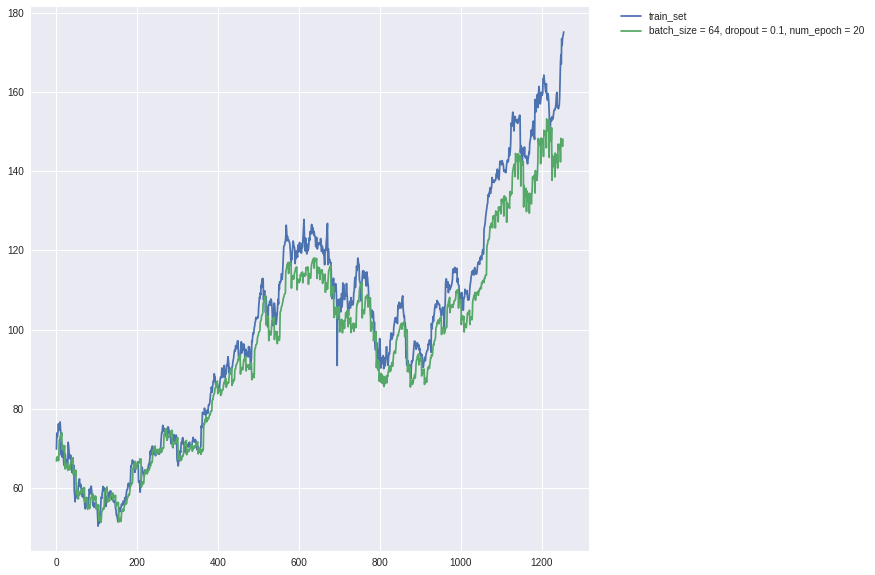

In [0]:
fig, ax = plt.subplots(figsize = (10, 10))
plt.plot(test[:, 0], label = 'train_set')
plt.plot(pred, label = 'batch_size = {}, dropout = {}, num_epoch = {}'.format(64, 0.1, 20))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)